In [4]:
# Load and prepare data
import pandas as pd
import numpy as np
import statsmodels.api as sm
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Load data
data = pd.read_csv('modified_spending_data.csv')
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y-%m-%d %H:%M:%S')

In [5]:
# Basic EDA
print("Dataset Shape:", data.shape)
print("\nData Info:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe())

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

Dataset Shape: (210, 3)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Timestamp          210 non-null    datetime64[ns]
 1   Spending_Category  210 non-null    object        
 2   Amount             210 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 5.0+ KB
None

Summary Statistics:
           Amount
count  210.000000
mean    31.435857
std     37.714657
min      1.040000
25%      6.510000
50%     17.465000
75%     36.267500
max    149.790000

Missing Values:
Timestamp            0
Spending_Category    0
Amount               0
dtype: int64


In [6]:
# Temporal analysis
data['Year'] = data['Timestamp'].dt.year
data['Month'] = data['Timestamp'].dt.month
data['DayOfWeek'] = data['Timestamp'].dt.dayofweek
data['Hour'] = data['Timestamp'].dt.hour

In [7]:
# Monthly patterns
monthly_spending = data.groupby('Month')['Amount'].agg(['sum', 'mean', 'count'])
fig_monthly = px.bar(monthly_spending, 
                    title='Monthly Spending Patterns',
                    labels={'value': 'Amount', 'Month': 'Month of Year'})
fig_monthly.show()

In [8]:
# Daily patterns
daily_patterns = data.groupby('DayOfWeek')['Amount'].mean()
fig_daily = px.bar(daily_patterns, 
                  title='Average Spending by Day of Week',
                  labels={'value': 'Average Amount', 'DayOfWeek': 'Day of Week (0=Monday)'})
fig_daily.show()

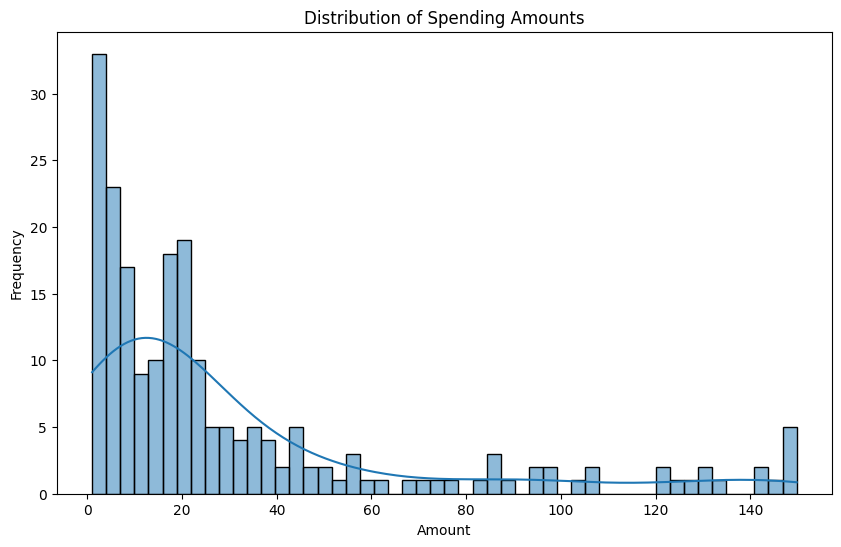

In [9]:
# Distribution of spending amounts
plt.figure(figsize=(10, 6))
sns.histplot(data['Amount'], bins=50, kde=True)
plt.title('Distribution of Spending Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

In [10]:
# Check for outliers using Z-score
z_scores = np.abs(stats.zscore(data['Amount']))
outliers = (z_scores > 3).sum()
print(f"\nNumber of outliers (Z-score > 3): {outliers}")


Number of outliers (Z-score > 3): 6


In [11]:
# Hourly patterns
hourly_spending = data.groupby('Hour')['Amount'].mean()
fig_hourly = px.line(hourly_spending, 
                     title='Average Spending by Hour of Day',
                     labels={'value': 'Average Amount', 'Hour': 'Hour of Day'})
fig_hourly.show()

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import plotly.graph_objects as go

data = pd.read_csv('modified_spending_data.csv')
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y-%m-%d %H:%M:%S')
data['Day'] = data['Timestamp'].dt.date
daily_data = data.groupby('Day')['Amount'].sum().reset_index()
daily_data['Day'] = pd.to_datetime(daily_data['Day'])
time_series_daily = daily_data.set_index('Day')['Amount']

sarima_model = sm.tsa.SARIMAX(
    time_series_daily,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_result = sarima_model.fit(disp=False)

forecast_steps = 1
forecast = sarima_result.get_forecast(steps=forecast_steps)
forecast_value = forecast.predicted_mean.iloc[0]

latest_date = data['Timestamp'].max().date()
cutoff_date = latest_date + pd.Timedelta(days=1)
end_of_month = cutoff_date + pd.offsets.MonthEnd(0)

forecast_index = pd.date_range(start=cutoff_date, end=end_of_month, freq='D')
historical_jan_data = data[data['Timestamp'].dt.month == cutoff_date.month]
historical_jan_data['Day'] = historical_jan_data['Timestamp'].dt.day
daily_avg = historical_jan_data.groupby('Day')['Amount'].sum() / historical_jan_data['Day'].nunique()
daily_forecast = daily_avg / daily_avg.sum() * forecast_value
remaining_forecast_index = pd.date_range(start=cutoff_date, end=end_of_month, freq='D')
remaining_forecast_values = daily_forecast.values[-len(remaining_forecast_index):]

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=time_series_daily.index,
    y=time_series_daily,
    mode='lines',
    name='Historical Data (Daily)',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=remaining_forecast_index,
    y=remaining_forecast_values,
    mode='lines',
    name=f'Forecast from {cutoff_date} to {end_of_month} (Daily)',
    line=dict(color='red', dash='dot')
))
fig.update_layout(
    title=f"Expenditure Forecast for {cutoff_date.strftime('%B %Y')} - Daily",
    xaxis_title="Date",
    yaxis_title="Expenditure Amount",
    template="plotly_white",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)
fig.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/var/folders/g5/w48lctm91g14byq5_rb_xvjw0000gn/T/ipykernel_98589/358235756.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See